# Natural Language Processing with Amazon Reviews

Developed for the second project of the Artificial Intelligence course

## Setup and Environment

After installing Python and the necessary packages, run the following code to import them:

In [49]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sb
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/joao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Implementation work

### Loading the data

In [51]:
train = pd.read_csv('./data/train.csv', dtype={'class_index': int, 'review_title': str, 'review_text': str}).sample(10000)  # Sample data with all classes uniformly
test = pd.read_csv('./data/test.csv', dtype={'class_index': int, 'review_title': str, 'review_text': str}).sample(2160)
train.head()


,class_index,review_title,review_text
1694927,4,Confessions of a spin-off junky:,Granted I had just read two VERY POORLY writte...
2557080,2,VHS Tape,This is a classic movie but the quality was po...
121692,3,"Waterproof, but is it safe for kids?",I purchased this mattress pad almost a year ag...
2619586,3,"one of cassie,s better ones",I hate to do this because i admire anyone who ...
40998,1,Baloney,This book is NOT the true story of life among ...


### Searching for null values

In [52]:
print("Columns with empty review text", len(train.loc[train['review_text'] == ""]))
print("Columns with missing review text", len(train.loc[train['review_text'] == None]))

print("Columns with empty review title", len(train.loc[train['review_title'] == ""]))
print("Columns with missing review title", len(train.loc[train['review_title'] == None]))

print("Columns with empty class index", len(train.loc[train['class_index'] == ""]))
print("Columns with missing class index", len(train.loc[train['class_index'] == None]))

Columns with empty review text 0
Columns with missing review text 0
Columns with empty review title 0
Columns with missing review title 0
Columns with empty class index 0
Columns with missing class index 0


As we can see, the dataset does not contain any empty or missing values

### Studying the data

<AxesSubplot:>

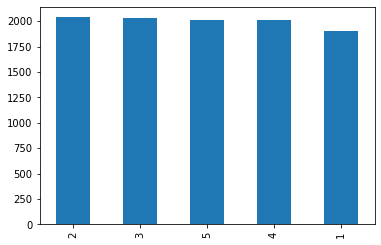

In [53]:
train['class_index'].value_counts().plot(kind='bar')

As the dataset creators have told us, the training dataset consists of 600 thousand samples for each review score, from 1 to 5.

##### Most frequent Words

/home/joao/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Words'), Text(0, 0.5, 'Occurrencies')]

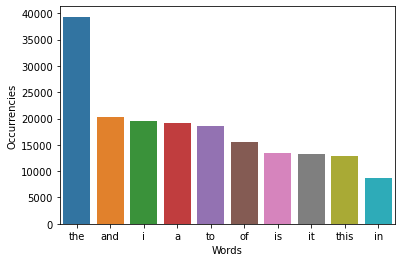

In [54]:
from collections import Counter

mostUsed = pd.Series(' '.join(train['review_text']).lower().split()).value_counts()[:10]
mostUsedGraph = sb.barplot(mostUsed.index, mostUsed.values)
mostUsedGraph.set(xlabel="Words", ylabel="Occurrencies")

### Treating the data
##### Cleanup and Normalization

In [55]:
ps = PorterStemmer()

def normalize(text):
    # remove non alpha chars
    text = re.sub('[^a-zA-Z]', ' ', text)   # TODO: CHECK THIS REGULAR EXPRESSION
    # to lower-case and tokenize
    text = text.lower().split()
    # stemming and stop word removal
    text = ' '.join([ps.stem(w) for w in text if not w in set(stopwords.words('english'))])

    return text


train['review_text'] = train['review_text'].apply(normalize)

train['review_title'] = train['review_title'].apply(normalize)
train.head()


test['review_text'] = test['review_text'].apply(normalize)
test['review_title'] = test['review_title'].apply(normalize)

##### Saving Preprocessed data
Since the original dataset is very large, we can sample it and save the preprocessed data in a different csv file, so it can be used later.

In [56]:
def savePreprocessedData(dataSet, fileName):
    dataSet.to_csv(fileName, index=False)

savePreprocessedData(train, './data/train_preprocessed.csv')
savePreprocessedData(test, './data/test_preprocessed.csv')

##### Generating wordclouds
A visually appealing way of observing words in a dataset is by showing wordclouds. In order to make a single wordcloud for a whole column, we can join all the cells together. We then pass it to WordCloud to generate a wordcloud: it will automatically assign weights to words based on the number of occurrences of each word.

These are the most common words in the reviews' titles:

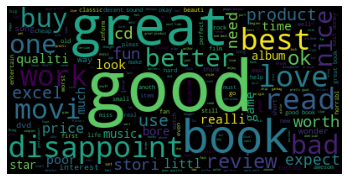

In [57]:
wordcloudTitle = WordCloud().generate(" ".join([str(x) for x in train['review_title'].values]))

plt.figure()
plt.imshow(wordcloudTitle)
plt.axis('off')
plt.show()

These are the most common words in the reviews' text:

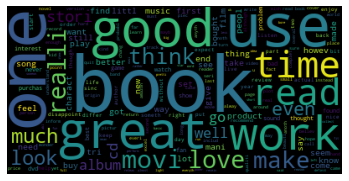

In [58]:
wordcloudText = WordCloud().generate(" ".join([str(x) for x in train['review_text'].values]))

plt.figure()
plt.imshow(wordcloudText)
plt.axis('off')
plt.show()

It would also be interesting to visualize a wordcloud for each of the reviews' classes (1 to 5):

Word cloud for class 1's titles:


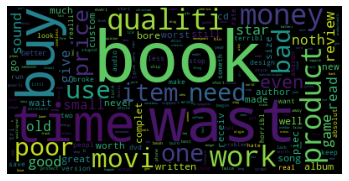

Word cloud for class 1's text:


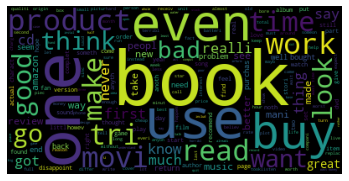

Word cloud for class 2's titles:


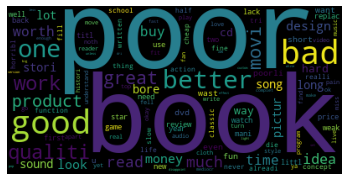

Word cloud for class 2's text:


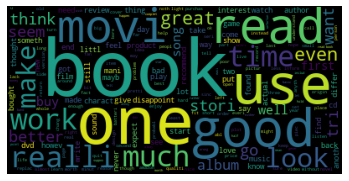

Word cloud for class 3's titles:


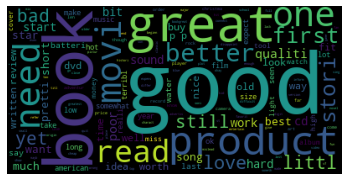

Word cloud for class 3's text:


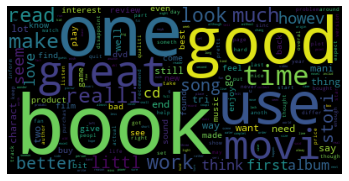

Word cloud for class 4's titles:


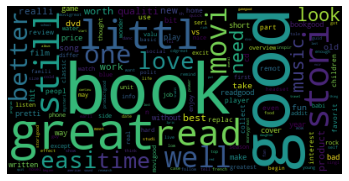

Word cloud for class 4's text:


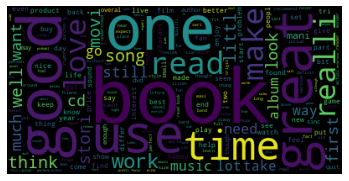

Word cloud for class 5's titles:


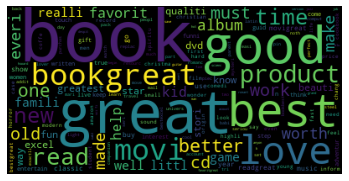

Word cloud for class 5's text:


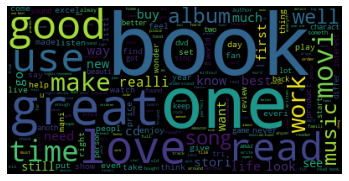

In [60]:
wordsPerClass = {
    1: ("", ""), # title and text
    2: ("", ""),
    3: ("", ""),
    4: ("", ""),
    5: ("", ""),
}

for i in range(len(train)):
    classId = int(train['class_index'].values[i])
    titleWords = train['review_title'].values[i]
    textWords = train['review_text'].values[i]
    
    wordsPerClass[classId] = (wordsPerClass[classId][0] + titleWords, wordsPerClass[classId][1] + textWords)

for i in range(1, 6):
    # Word cloud for class's titles
    wordcloudTitle = WordCloud().generate(wordsPerClass[i][0])
    print(f"Word cloud for class {i}'s titles:")

    plt.figure()
    plt.imshow(wordcloudTitle)
    plt.axis('off')
    plt.show()

    # Word cloud for class's text
    wordcloudText = WordCloud().generate(wordsPerClass[i][1])
    print(f"Word cloud for class {i}'s text:")

    plt.figure()
    plt.imshow(wordcloudText)
    plt.axis('off')
    plt.show()

### Generating a data set
#### Obtaining features from the Bag-of-Words model

In [ ]:
train = pd.read_csv('./data/train_preprocessed.csv')
test = pd.read_csv('./data/test_preprocessed.csv')

vectorizer = CountVectorizer()

trainArr = map(str, train['review_title'])

titleWords = vectorizer.fit_transform(trainArr).toarray()

print(titleWords.shape)
print(vectorizer.get_feature_names())

### Obtaining the Test classes

In [73]:
y = train['class_index']

# print(X.shape, y.shape)

### Training Classifiers

In [74]:
clf = MultinomialNB()
clf.fit(titleWords, y)

testArr = map(str, test['review_title'])
testVector = vectorizer.transform(testArr).toarray()

y_pred = clf.predict(testVector)
print(y_pred)

[5 4 2 ... 5 2 4]


### Analyse Results

In [75]:
# confusion matrix
confusionMatrix = confusion_matrix(test['class_index'], y_pred)
print(confusionMatrix)

correctReviews = 0
for i in range(len(confusionMatrix)):
    correctReviews += confusionMatrix[i][i]

incorrectReviews = sum(map(sum, confusionMatrix)) - correctReviews
print("correctReviews:", correctReviews)
print("incorrectReviews:", incorrectReviews)

accuracy = (correctReviews / (incorrectReviews + correctReviews)) * 100

# accuracy, precision, recall, f1
# your code here
print("Accuracy:", accuracy)
#print("Precision:", precision)
#print("Recall:", recall)
#print("F1:", f1)

[[169 125  52  30  37]
 [ 84 140  91  71  62]
 [ 47 102 148  80  65]
 [ 27  71  89 125 113]
 [ 28  62  54  84 204]]
correctReviews: 786
incorrectReviews: 1374
Accuracy: 36.388888888888886
